In [87]:
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [88]:
import importlib
try: 
    importlib.reload(generators)
    importlib.reload(utils)
    importlib.reload(trainers)
    importlib.reload(u_net)
    print("libs reloaded")
except:
    import generators
    import trainers
    import utils
    import u_net
    print("libs imported")

TrainerUNET = trainers.TrainerUNET

libs reloaded


# UNET

In [89]:
# directorys with data and to store training checkpoints and logs
WORKING_DIR = Path(r"C:\Users\marti\OneDrive - TU Eindhoven\Documenten\Master\Q3\Capita Selecta\Project")
DATA_DIR = WORKING_DIR / "Data"
PROGRESS_DIR = WORKING_DIR / "progress_unet"
PROGRESS_DIR.mkdir(parents=True, exist_ok=True)
VAE_WEIGHTS = WORKING_DIR / "progress_vae" / "exp" / "model.pth"
VAEGAN_WEIGHTS = WORKING_DIR / "progress_vaegan" / "exp" / "model.pth"

# training settings and hyperparameters
NO_VALIDATION_PATIENTS = 3
IMAGE_SIZE = [64, 64]  # images are made smaller to save training time
N = 15
train_size = N-NO_VALIDATION_PATIENTS
seed = 0
BATCH_SIZE = 32
N_EPOCHS = 100
LEARNING_RATE = 1e-4
TOLERANCE = 0.01  # for early stopping
DISPLAY_FREQ = 5
RATIO = 1/10
exp = str(N_EPOCHS) + '_epochs_' + str(RATIO) + "_ratio"
EXPERIMENT_DIR = PROGRESS_DIR / exp
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]

train_indx, valid_indx = train_test_split(patients, random_state=seed, train_size=train_size)

# split in training/validation after shuffling
partition = {
    "train": train_indx,
    "validation": valid_indx,
}

mask_generator = generators.VAE
# mask_generator.load_state_dict(torch.load(VAE_WEIGHTS))
# mask_generator.eval()

image_generator = generators.VAEGAN
# image_generator.load_state_dict(torch.load(VAEGAN_WEIGHTS))
# image_generator.eval()

# load training data and create DataLoader with batching and shuffling
train_set = utils.ProstateMRUNETDataset(partition["train"], IMAGE_SIZE)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

# load validation data
valid_set = utils.ProstateMRUNETDataset(partition["validation"], IMAGE_SIZE)
valid_loader = DataLoader(
    valid_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

# initialise model, optimiser, and loss function
unet_model = u_net.UNet(num_classes=1).to(device)
optimizer = torch.optim.Adam(unet_model.parameters(), lr=LEARNING_RATE)

u_net_trainer = TrainerUNET(net=unet_model, 
                            optimizer=optimizer, 
                            progress_dir=EXPERIMENT_DIR, 
                            train_loader=train_loader, 
                            valid_loader=valid_loader, 
                            mask_generator=mask_generator,
                            image_generator=image_generator,
                            RATIO=RATIO,
                            CHECKPOINTS_DIR=EXPERIMENT_DIR, 
                            device=device) 

In [90]:
u_net_trainer.train(N_EPOCHS, 1)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #000: DiceBCELoss/train = 1.541 | DiceBCELoss/valid = 1.194


  0%|          | 0/32 [00:00<?, ?it/s]

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

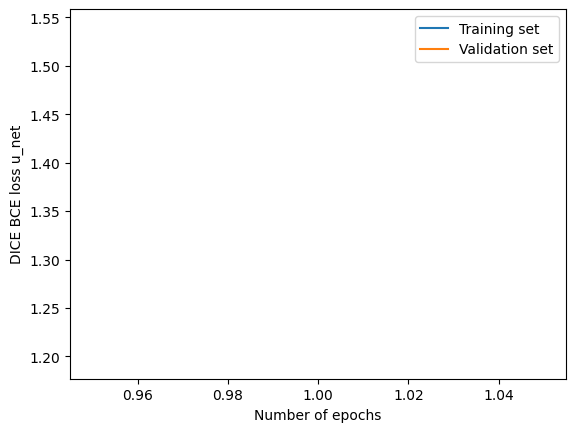

In [92]:
plt.plot(range(1, len(u_net_trainer.train_losses[0])+1), u_net_trainer.train_losses[0])
plt.plot(range(1, len(u_net_trainer.train_losses[0])+1), u_net_trainer.valid_losses[0])
plt.xlabel('Number of epochs')
plt.ylabel('DICE BCE loss u_net')
plt.legend(['Training set', 'Validation set'])
plot_name = 'DICE_BCE_LOSS_'+ str(N_EPOCHS) + '_epochs_' + str(RATIO) + '_ratio.png'
path = EXPERIMENT_DIR / plot_name

plt.savefig(path, dpi=200)